# Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [1]:
## Import Raw Data, convert to_datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as sig
# import scipy.stats as stats

import mylib as my

## IMPORT
dl1 = my.import_csv("../data/DL1March_May_24.csv")
dl3 = my.import_csv("../data/DL3March_May_24.csv")

## CONSTANTS
from myconstants import *

Power (kW)


# Time-Series Analysis
This section will consist of plotting every data point we have in time in order to establish a relationship between periods of the year and our variables.

Let's only consider DL1 for now: both datasets we have so far are only sampling servers. Now, time to plot the raw data.
## Raw Data Plotting

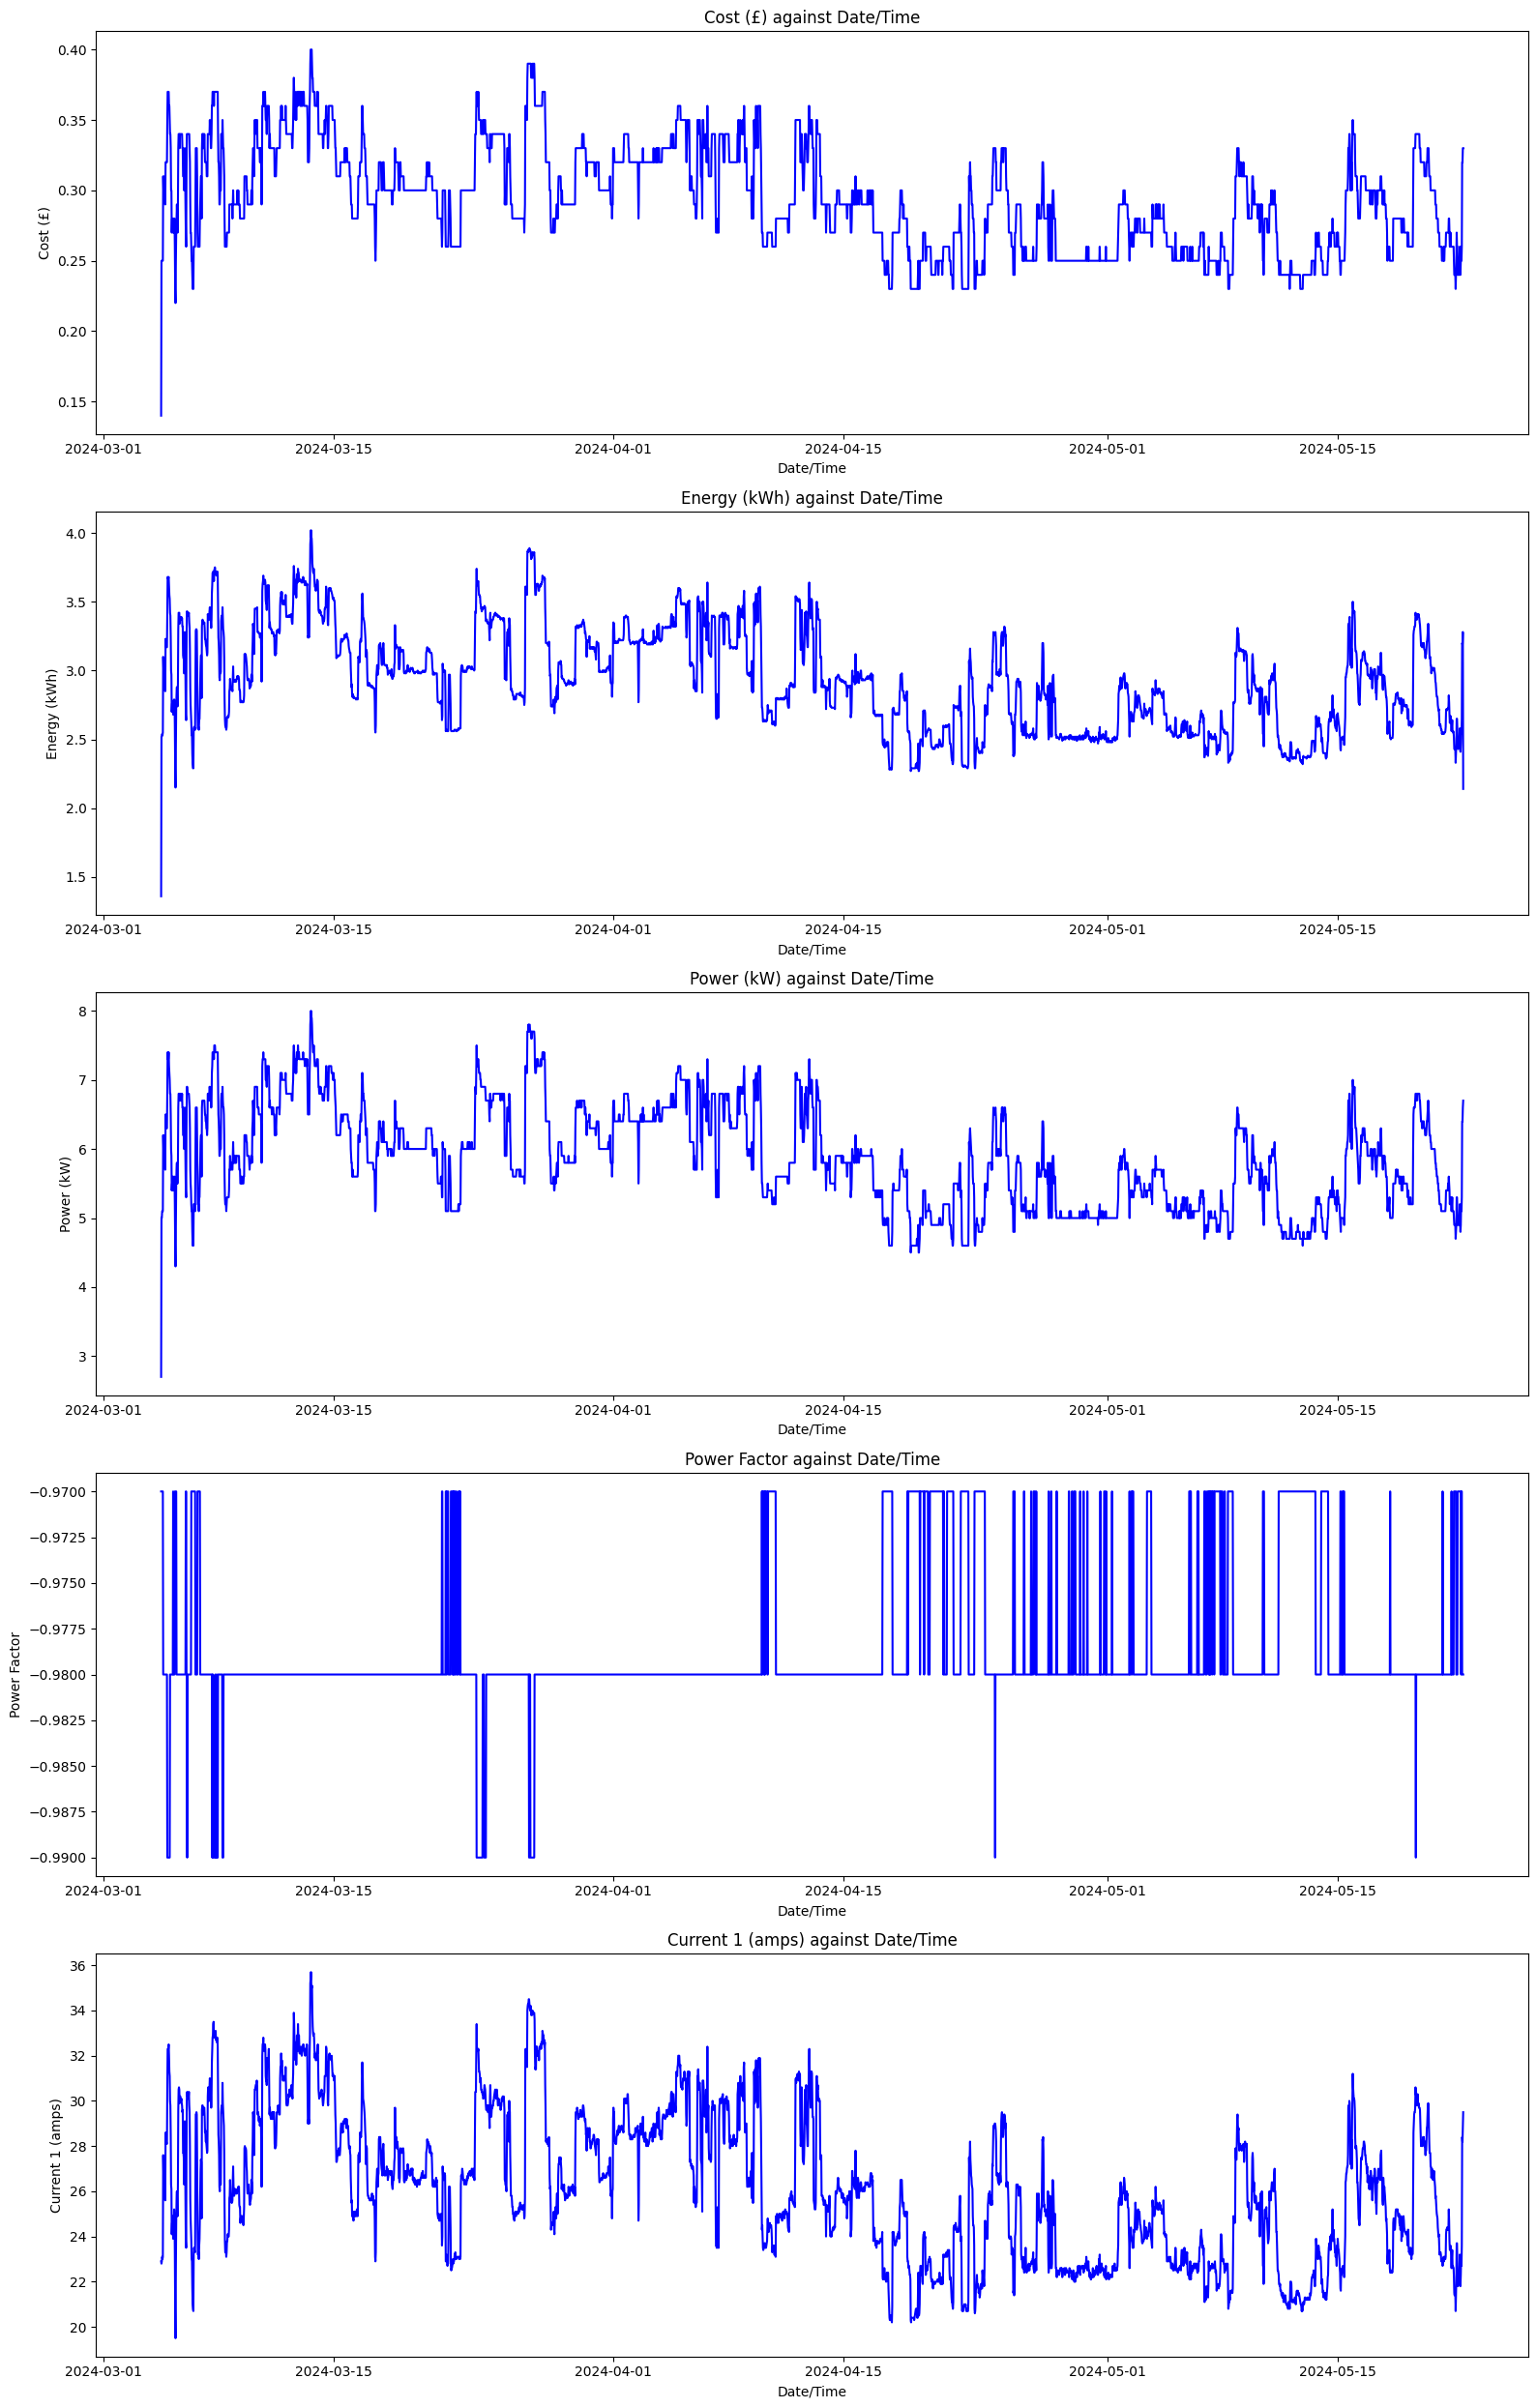

In [2]:
my.plot_raw_data(dl1, figsize=FIGSIZE)

Note that most of these are very similar, as proved by the correlation matrix below, where nearly all variables have a correlation coefficient of 1.
This also makes sense intuitively: cost is directly proportional to energy consumed, as per the energy provider; the sampling time is constant at twice per hour, so the energy will also be linearly linked to the power; and finally, assuming the supply voltage stays constant throughout, power and current are also directly proportional to one another. Power factor is separate, but its stableness indicates that our assumption about stable voltage supply is accurate.

In [3]:
HEADER = "Power (kW)" # DO NOT MODIFY

## Important Dates
During these times, there were bank holidays, campus closure times, as well as a switch from term time to holiday time. As the servers are mostly used by MsC and PhD students, usually overnight, it is expected that the power consumption over that time remains relatively constant. Here, we will distiguish between power consumption on weekends, bank holidays, term time, and campus closure.

To distinguish between which variable is being analysed, a HEADER variable will be defined. It must not be touched at all times.

### Bank Holidays & Campus Closure
The dates were pulled manually from the official imperial website.

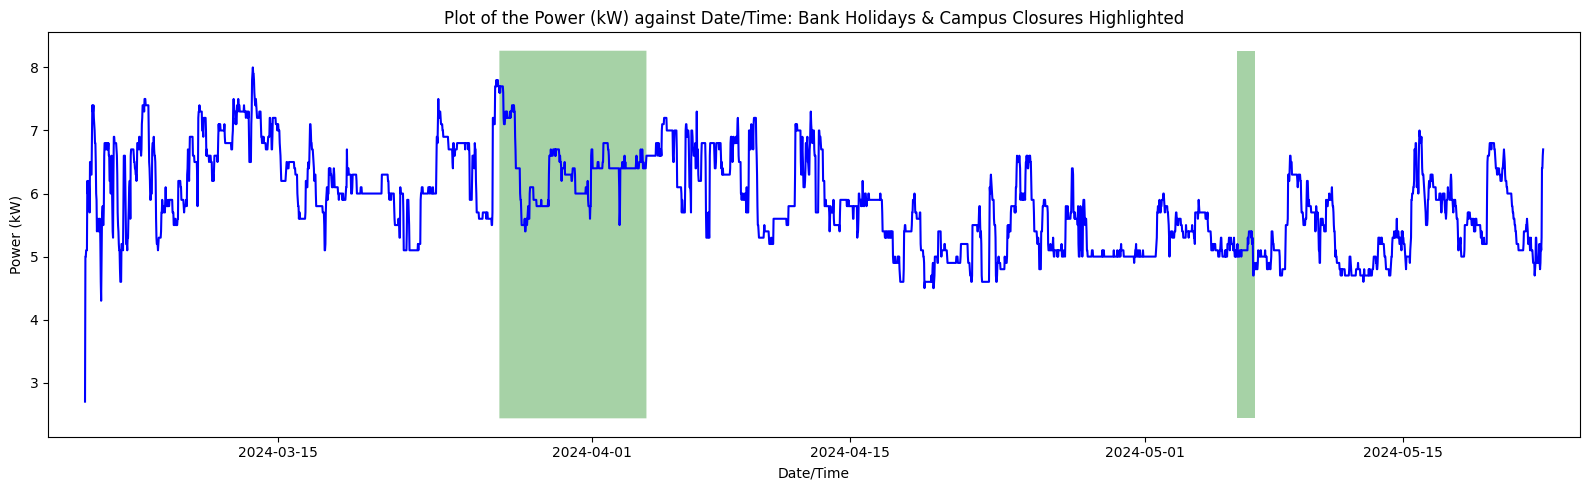

In [4]:
# bank holidays + campus closure

# initialize figure
plt.figure(figsize=FIGSIZE)
plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
vertical_limits = plt.gca().get_ylim()
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.normalize() in bank_holidays for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
# plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.tight_layout()
plt.show()

### Term Time
Again, term time dates were pulled from Imperial's official website.

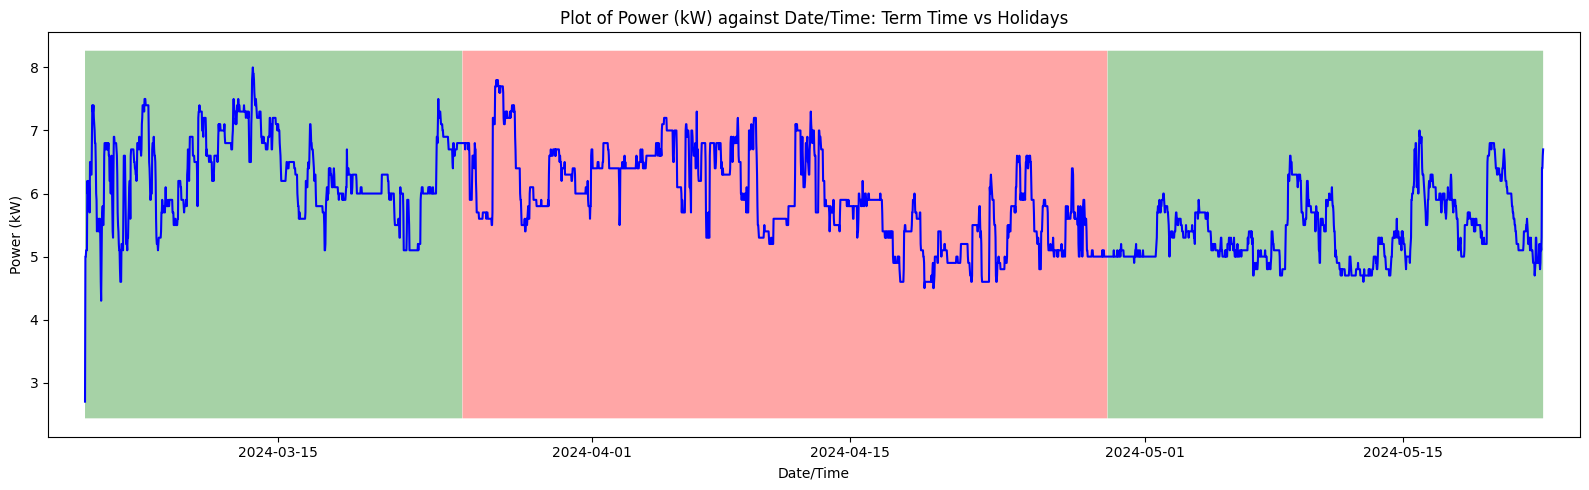

In [5]:
# Term Time relation to power consumption

plt.figure(figsize=FIGSIZE)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
vertical_limits = plt.gca().get_ylim()
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() not in spring_term and time.normalize() not in summer_term for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() in spring_term or time.normalize() in summer_term for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of " + HEADER + " against Date/Time: Term Time vs Holidays")
    
plt.tight_layout()
plt.show()

## Weekends vs Weekdays
Here, we will analyse the difference between weekdays, weekends, both individually and as a group. This will include an analysis for each individual day of the week, taking its expected consumption during the day, as well as taking the expected consumption through the week, though the hourly consumption by day will be explored later 

Mean total Power (kW): 5.872274881516588 kW
Median total Power (kW): 5.8 kW

Mean Weekend Power (kW): 5.802935606060607
Mean Weekdays Power (kW): 5.898978847556528
Mean Power (kW) on Monday: 5.881306715063521
Mean Power (kW) on Tuesday: 5.813541666666667
Mean Power (kW) on Wednesday: 5.94293381037567
Mean Power (kW) on Thursday: 6.030681818181819
Mean Power (kW) on Friday: 5.832386363636363
Mean Power (kW) on Saturday: 5.824053030303031
Mean Power (kW) on Sunday: 5.781818181818182
Median Power (kW) on Monday: 6.0
Median Power (kW) on Tuesday: 5.7
Median Power (kW) on Wednesday: 6.0
Median Power (kW) on Thursday: 5.9
Median Power (kW) on Friday: 5.8
Median Power (kW) on Saturday: 5.7
Median Power (kW) on Sunday: 5.8


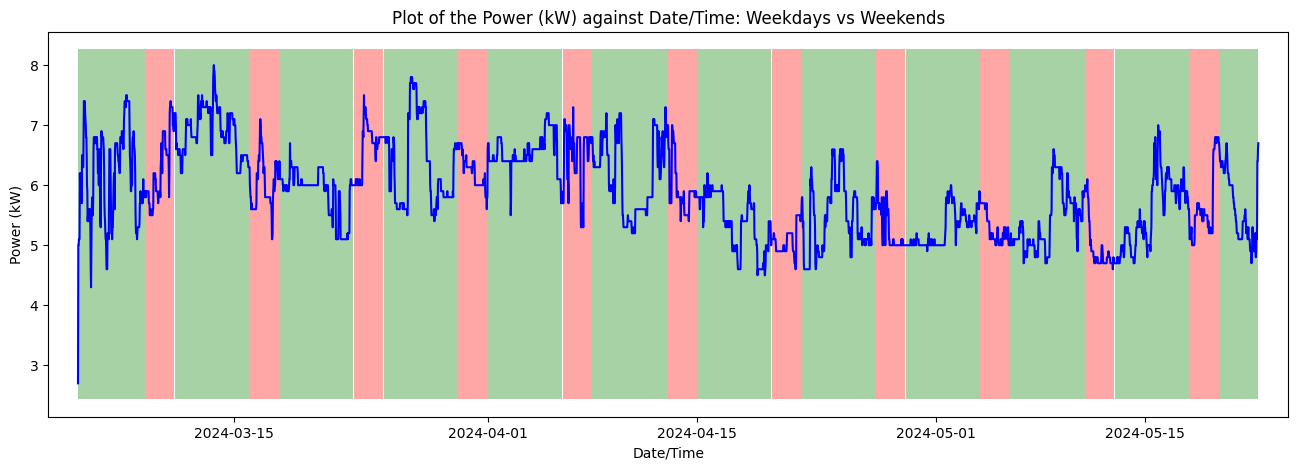

Text(0.5, 1.0, 'Power (kW) for each day of the week')

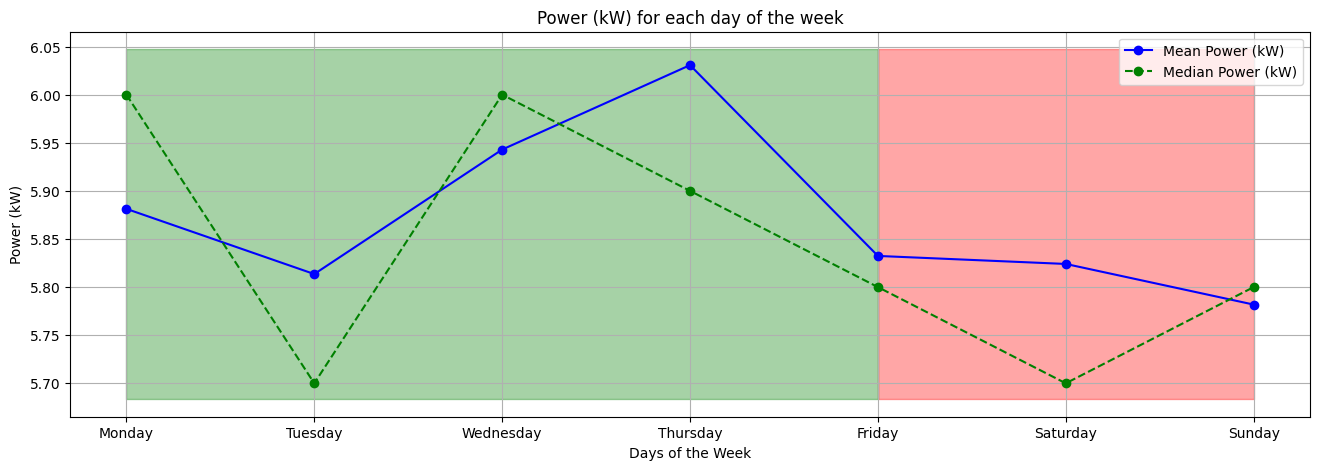

In [6]:
## Mean and median total consumption
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# dl1_days = dl1[HEADER].groupby(dl1["Date/Time"].dt.weekday).apply(list)
dl1_days = my.separate_by_weekdays(dl1[HEADER], HEADER)


## FIG1
plt.figure(figsize=FIGSIZE)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
vertical_limits = plt.gca().get_ylim()
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() == 5 or time.weekday() == 6 for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() != 5 and time.weekday() != 6 for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Weekdays vs Weekends")
    
plt.show()
## FIG2
plt.figure(figsize=FIGSIZE)
plt.plot([np.mean(dl1_days[i]) for i in range(7)], color='b', linestyle='-', marker='o', label='Mean ' + HEADER)
plt.plot([np.median(dl1_days[i]) for i in range(7)], color='g', linestyle='--', marker='o', label='Median ' + HEADER)
vertical_limits = plt.gca().get_ylim()
plt.fill_between(range(4, 7), vertical_limits[0], vertical_limits[1], 
                 where=[True]*3, color='r', alpha=0.35)
plt.fill_between(range(5), vertical_limits[0], vertical_limits[1], 
                 where=[True]*5, color='g', alpha=0.35)

plt.xticks(range(7), days_of_the_week)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel("Days of the Week")
plt.ylabel(HEADER)
plt.ylim()
plt.title(HEADER + " for each day of the week")

## Throughout the Day
### Day vs Night & Working Day vs Night Analysis
Here we will define the day on the clock as 6am-6pm. Alternatively, we will also explore the working day from 9am-5pm, as it could also yield interesting results.

Clock Day Average: 5.804048370136698
Clock Night Average: 5.940717299578059

Working Day Average: 5.801968503937008
Working Night Average: 5.907594936708861


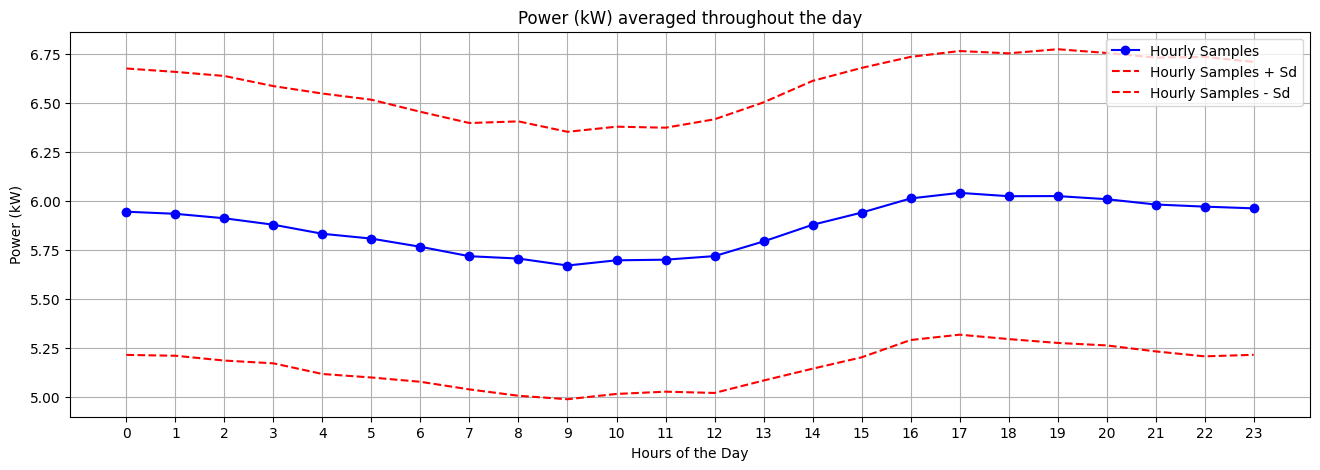

In [7]:
hourly_samples = dl1[HEADER].groupby(dl1["Date/Time"].dt.hour).apply(list)
hourly_samples_mean = [np.mean(hourly_samples[i]) for i in range(len(hourly_samples))]
hourly_samples_std = [np.std(hourly_samples[i]) for i in range(len(hourly_samples))]

day_clock = [hourly_samples[i][j] for i in range(6, 18) for j in range(len(hourly_samples[i]))]
day_working = [hourly_samples[i][j] for i in range(9, 17) for j in range(len(hourly_samples[i]))]
night_clock = [hourly_samples[i][j] for i in list(range(6))+list(range(18, 24)) for j in range(len(hourly_samples[i])) ]
night_working = [hourly_samples[i][j] for i in list(range(9))+list(range(17, 24)) for j in range(len(hourly_samples[i]))]

print("Clock Day Average: " + str(np.mean(day_clock)))
print("Clock Night Average: " + str(np.mean(night_clock)))
print("\nWorking Day Average: " + str(np.mean(day_working)))
print("Working Night Average: " + str(np.mean(night_working)))

plt.figure(figsize=FIGSIZE)
plt.plot(hourly_samples_mean, color='b', linestyle='-', marker='o', label='Hourly Samples')
plt.plot(np.add(hourly_samples_mean, hourly_samples_std), color='r', linestyle='--', label='Hourly Samples + Sd')
plt.plot(np.subtract(hourly_samples_mean, hourly_samples_std), color='r', linestyle='--', label='Hourly Samples - Sd')
plt.xticks(range(24), [str(i) for i in range(24)])
plt.grid()
plt.xlabel("Hours of the Day")
plt.ylabel(HEADER)
plt.title(HEADER + " averaged throughout the day")
plt.legend(loc='upper right')
plt.show()

### For Each Day of the Week
Explore contract terms and conditions.

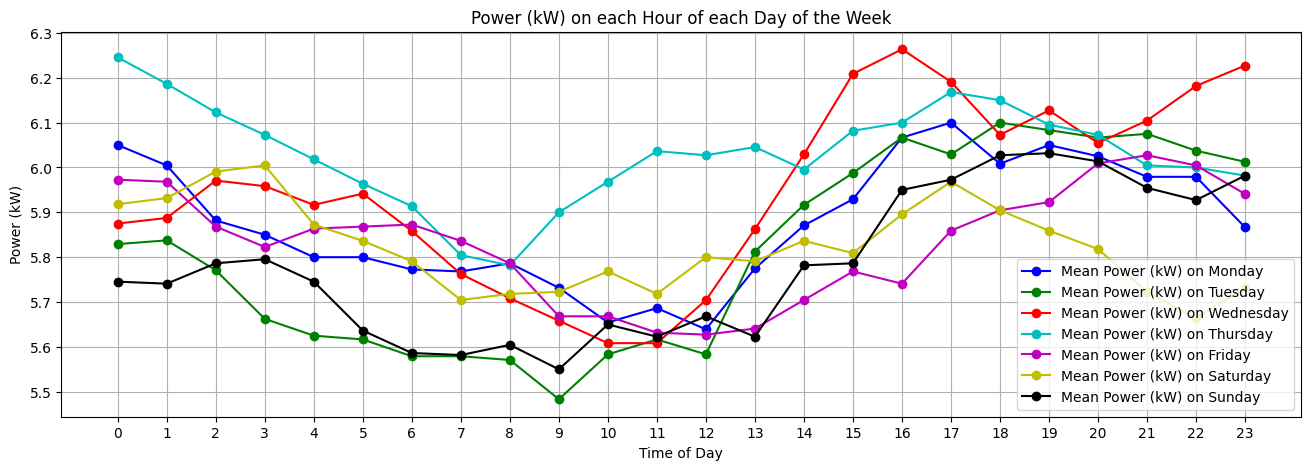

Text(0.5, 1.0, 'Power (kW) for each day of the week, during the day')

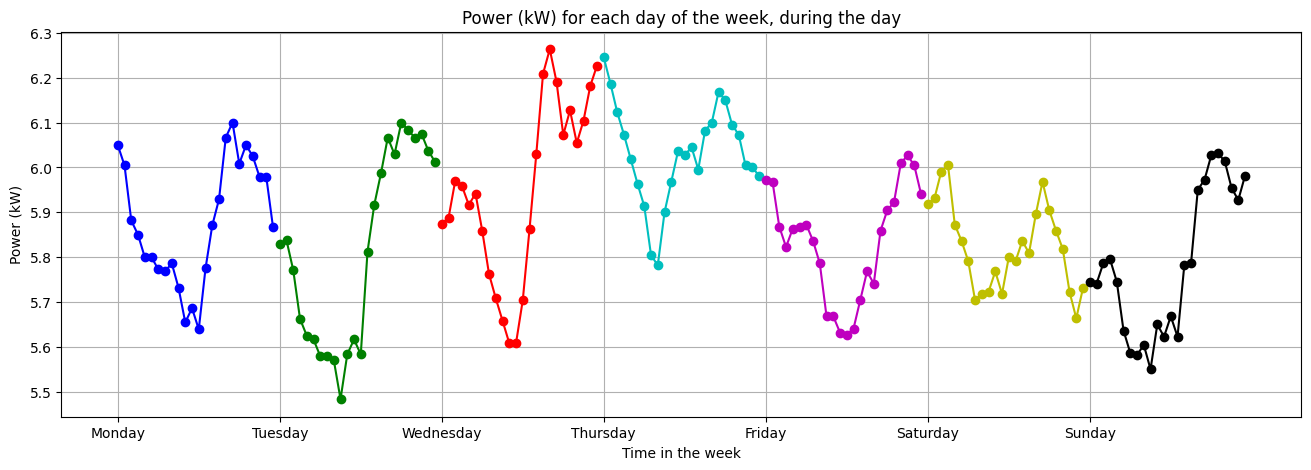

In [8]:
# Group Readings by day of week AND hour using pd.groupby
daily_hourly_samples = dl1.groupby([dl1["Date/Time"].dt.weekday, dl1["Date/Time"].dt.hour])[HEADER].apply(list).to_dict()
days_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k'}

plt.figure(figsize=FIGSIZE)
for i in range(7):
    plt.plot([np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], 
             color=colors[i], linestyle='-', marker='o', label='Mean ' + HEADER + ' on ' + days_of_the_week[i])
plt.xticks(range(24), [str(j) for j in range(24)])
plt.xlabel("Time of Day")
plt.ylabel(HEADER)
plt.legend(loc='lower right')
plt.grid()
plt.title(HEADER + " on each Hour of each Day of the Week")
plt.show()


plt.figure(figsize=FIGSIZE)
for i in range(7):
    plt.plot(range(i*24, 24*(i+1)), [np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], 
             color=colors[i], linestyle='-', marker='o', label='Mean ' + HEADER + ' on ' + days_of_the_week[i])
plt.xticks(range(0, 24*7, 24), days_of_the_week.values())
plt.grid()
plt.xlabel("Time in the week")
plt.ylabel(HEADER)
plt.title(HEADER+" for each day of the week, during the day")
# build on this: make a color per day and make it fancy

## Weather Correlation 
Weather data was pulled from
https://meteostat.net/en/place/gb/london?s=03779&t=2024-03-04/2024-05-22

To import the data, the same process as before can be used, taking care to import the date and time as a pandas datetime.
Again, we will plot the raw data.

It turns out, the pandas correlation function alignst the series sample by sample, with no regard to when the sample was taken. Therefore, we will modify the power consumption to reflect the average daily power consumption.

The correlation between average temperature and power consumption is: -0.13850431632499344


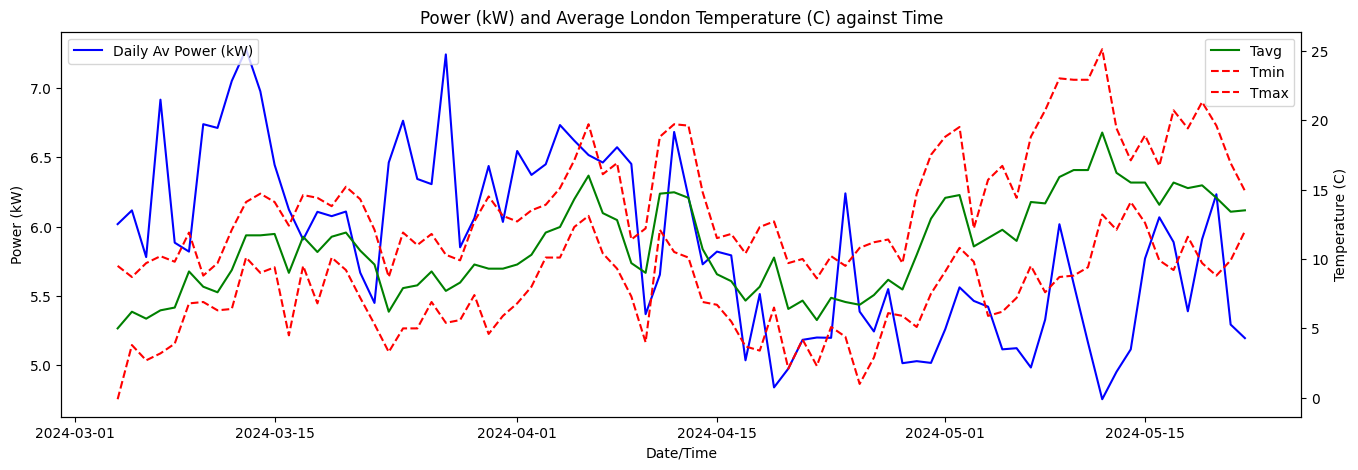

In [9]:
weather = pd.read_csv("../data/London_Daily_Weather.csv").drop(columns=["tsun", "pres"]).fillna(0.0)
weather["date"] = pd.to_datetime(weather["date"], format='%Y-%m-%d', utc=True)
weather.set_index(['date'], inplace=True, drop=False)

dl1_averages = dl1[HEADER].groupby(dl1["Date/Time"].dt.normalize()).mean()

print("The correlation between average temperature and power consumption is: " + str(dl1_averages.corr(weather["tavg"])))

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel("Date/Time")
ax.set_ylabel(HEADER)
ax.plot(dl1_averages.index, dl1_averages, color='b', linestyle='-', label='Daily Av ' + HEADER)
# ax.plot(dl1["Date/Time"], dl1[HEADER], color='m', linestyle='-', label='regular ' + HEADER, alpha=0.5)
plt.legend(loc='upper left')

ax = ax.twinx()

ax.set_ylabel("Temperature (C)")
ax.plot(weather["date"], weather["tavg"], color='g', label='Tavg', linestyle='-')
ax.plot(weather["date"], weather["tmin"], color='r', label='Tmin', linestyle='--')
ax.plot(weather["date"], weather["tmax"], color='r', label='Tmax', linestyle='--')
plt.title(HEADER+" and Average London Temperature (C) against Time")
plt.legend(loc='upper right')
plt.show()

## Rates of Change
It could be interesting to explore rates of change: to see when the servers have an instant increase in activity. This could allow us to prepare for a period of time we can expect an increase / decrease in activity.

Text(0.5, 1.0, 'Derivative of Power against Date/Time')

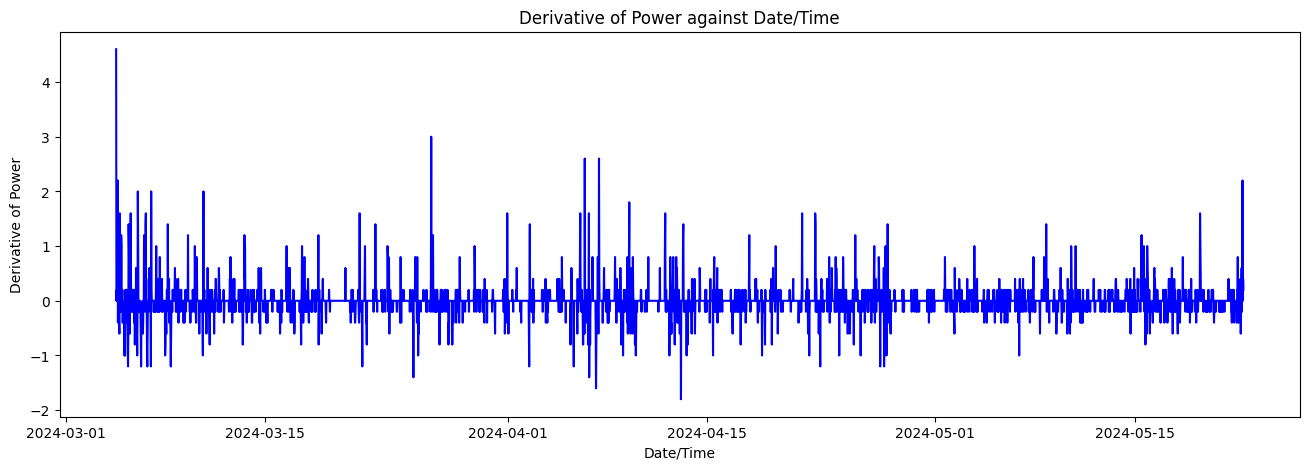

In [10]:
# der = [(dl1[HEADER].iloc[i+1] - dl1[HEADER].iloc[i])*2 for i in range(len(dl1)-1)]
der = dl1[HEADER].rolling(window=2).apply(lambda lst: (lst.iloc[1] - lst.iloc[0])*2)

plt.figure(figsize=FIGSIZE)
plt.plot(dl1.index, der, color='b', linestyle='-')
plt.xlabel("Date/Time")
plt.ylabel("Derivative of Power")
plt.title("Derivative of Power against Date/Time")

Text(0.5, 1.0, 'Derivative of Power against Date/Time')

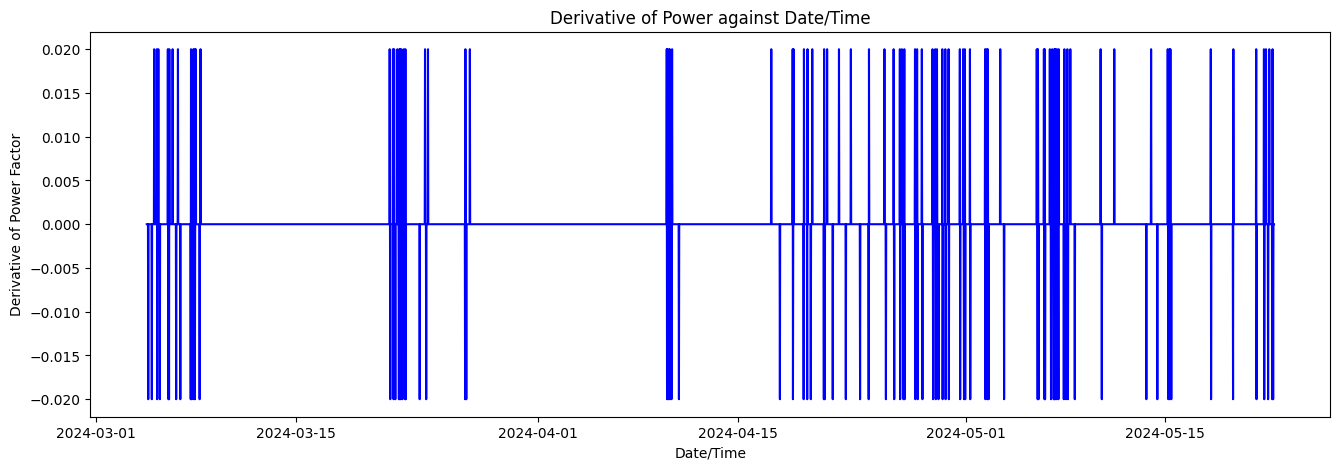

In [11]:
der_pf = dl1['Power Factor'].rolling(window=2).apply(lambda lst: (lst.iloc[1] - lst.iloc[0])*2)

plt.figure(figsize=FIGSIZE)
plt.plot(dl1.index, der_pf, color='b', linestyle = '-')
plt.xlabel("Date/Time")
plt.ylabel("Derivative of Power Factor")
plt.title("Derivative of Power against Date/Time")

## Moving Average Analysis

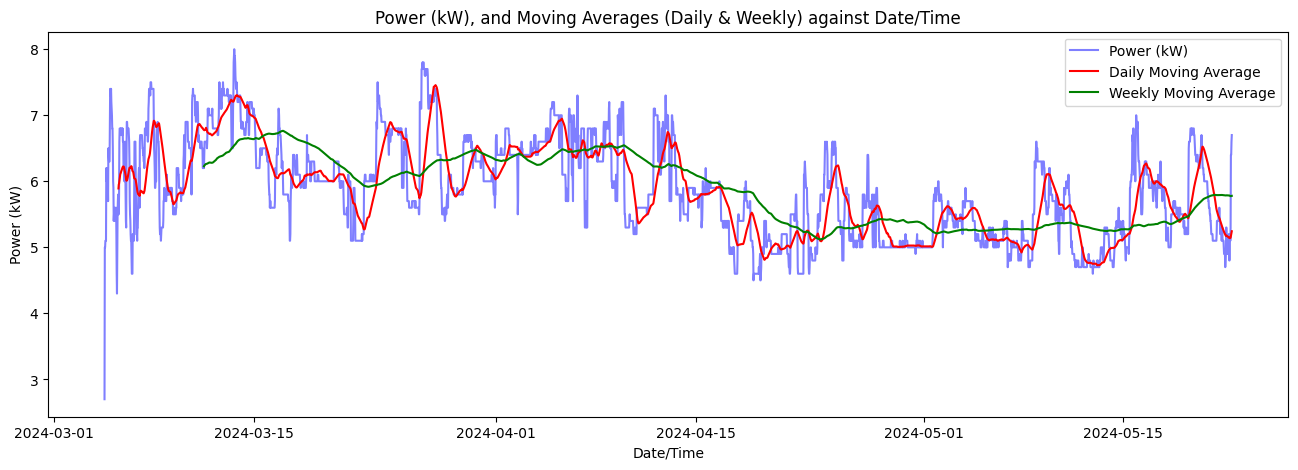

In [12]:
dl1[HEADER + " Moving Av Daily"] = dl1[HEADER].rolling(window=24*2).mean()
dl1[HEADER + " Moving Av Weekly"] = dl1[HEADER].rolling(window=24*2*7).mean()

plt.figure(figsize=(16,5))
plt.plot(dl1["Date/Time"], dl1[HEADER], label=HEADER, color='b', alpha=0.5)
plt.plot(dl1["Date/Time"], dl1[HEADER + " Moving Av Daily"], label='Daily Moving Average', color='r')
plt.plot(dl1["Date/Time"], dl1[HEADER + " Moving Av Weekly"], label='Weekly Moving Average', color='g')
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.legend(loc='upper right')
plt.title(HEADER + ", and Moving Averages (Daily & Weekly) against Date/Time")
plt.show()